In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [40]:
import sys
sys.path.append('../qubo')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import polynomial
import h5py
import matplotlib.backends.backend_pdf

## Inventory ##

In [2]:
d = pd.read_hdf('../qubo/data/partitions/analysis/inventory.h5')

In [3]:
d.loc['data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5']

,NLogQubits,NPhysQubits,SuccessProbability,embedding,energy,exact,isValid,maxCoefficientRangeRatio,maxCoefficientRangeRatioEmbedded,penalty_weight_conflict,penalty_weight_unique,repeatTo99,version
instance,,,,,,,,,,,,,
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,68.0,0.1561,0.0,0.166667,False,True,3.0,16.000000,0.5,0.5,27.13372,b72af7783d9db7600b6c9ece59b688f9c6da2288
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,59.0,0.1561,1.0,0.166667,False,True,3.0,16.000000,0.5,0.5,27.13372,b72af7783d9db7600b6c9ece59b688f9c6da2288
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,65.0,0.1561,2.0,0.166667,False,True,3.0,16.000000,0.5,0.5,27.13372,b72af7783d9db7600b6c9ece59b688f9c6da2288
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,60.0,0.1561,3.0,0.166667,False,True,3.0,16.000000,0.5,0.5,27.13372,b72af7783d9db7600b6c9ece59b688f9c6da2288
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,64.0,0.1561,4.0,0.166667,False,True,3.0,16.000000,0.5,0.5,27.13372,b72af7783d9db7600b6c9ece59b688f9c6da2288
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,66.0,0.0001,0.0,0.833333,False,True,6.0,18.400000,1.0,1.0,46049.39924,b72af7783d9db7600b6c9ece59b688f9c6da2288
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,61.0,0.0001,1.0,0.833333,False,True,6.0,18.400000,1.0,1.0,46049.39924,b72af7783d9db7600b6c9ece59b688f9c6da2288
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,65.0,0.0001,2.0,0.833333,False,True,6.0,18.400000,1.0,1.0,46049.39924,b72af7783d9db7600b6c9ece59b688f9c6da2288
data/partitions/instances/atm_instance_partition0001_delayStep003_maxDelay018.h5,14,57.0,0.0001,3.0,0.833333,False,True,6.0,18.400000,1.0,1.0,46049.39924,b72af7783d9db7600b6c9ece59b688f9c6da2288


## Add number of conflicts, number of flights and partition number as columns to the inventory ##

In [4]:
d = pd.read_hdf('../qubo/data/partitions/analysis/inventory.h5')
d.reset_index(inplace=True)

In [5]:
def parseInstance(instancefile):
    substr = instancefile.split('instances/')[1]
    delay = int(substr.split('_delayStep')[1].split('_maxDelay')[0])
    partition = int(substr.split('_partition')[1].split('_delayStep')[0])
    maxDelay = int(substr.split('_maxDelay')[1].split('.h5')[0])
    # get number of flights and conflicts
    instancefile = '../qubo/data/partitions/instances/atm_instance_partition%04i_delayStep%03i_maxDelay%03i.h5' % (partition, delay, maxDelay)
    f = h5py.File(instancefile, 'r')
    flights = f['atm-instance'].attrs['Number of flights']
    conflicts = f['atm-instance'].attrs['Number of conflicts']
    f.close()


    return delay, partition, flights, conflicts

In [6]:
info = np.array([list(parseInstance(i)) for i in d.instance.values])

In [7]:
d['delayStep'] = info[:, 0]
d['partitionNumber'] = info[:, 1]
d['numFlights'] = info[:, 2]
d['numConflicts'] = info[:, 3]

In [8]:
inventoryProcessed = d.set_index('instance')

In [9]:
inventoryProcessed.to_csv('inventoryProcessed.csv')

In [10]:
inventoryProcessed.set_index(['numFlights', 'numConflicts', 'delayStep']).head()

NLogQubits  NPhysQubits  \
numFlights numConflicts delayStep                            
2          3            3                  14         36.0   
                        3                  14         36.0   
                        3                  14         36.0   
                        3                  14         36.0   
                        3                  14         36.0   

                                   SuccessProbability  embedding  energy  \
numFlights numConflicts delayStep                                          
2          3            3                       0.602        0.0     0.0   
                        3                       0.602        1.0     0.0   
                        3                       0.602        2.0     0.0   
                        3                       0.602        3.0     0.0   
                        3                       0.602        4.0     0.0   

                                   exact isValid  maxCoefficientRangeRatio  \
numFlights numConflicts delayStep                                            
2          3            3          False    True                       3.0   
                        3          False    True                       3.0   
                        3          False    True                       3.0   
                        3          False    True                       3.0   
                        3          False    True                       3.0   

                                   maxCoefficientRangeRatioEmbedded  \
numFlights numConflicts delayStep                                     
2          3            3                                       8.0   
                        3                                       8.0   
                        3                                       8.0   
                        3                                       8.0   
                        3                                       8.0   

                                   penalty_weight_conflict  \
numFlights numConflicts delayStep                            
2          3            3                              0.5   
                        3                              0.5   
                        3                              0.5   
                        3                              0.5   
                        3                              0.5   

                                   penalty_weight_unique  repeatTo99  \
numFlights numConflicts delayStep                                      
2          3            3                            0.5     4.99854   
                        3                            0.5     4.99854   
                        3                            0.5     4.99854   
                        3                            0.5     4.99854   
                        3                            0.5     4.99854   

                                                                    version  \
numFlights numConflicts delayStep                                             
2          3            3          b72af7783d9db7600b6c9ece59b688f9c6da2288   
                        3          b72af7783d9db7600b6c9ece59b688f9c6da2288   
                        3          b72af7783d9db7600b6c9ece59b688f9c6da2288   
                        3          b72af7783d9db7600b6c9ece59b688f9c6da2288   
                        3          b72af7783d9db7600b6c9ece59b688f9c6da2288   

                                   partitionNumber  
numFlights numConflicts delayStep                   
2          3            3                        8  
                        3                        8  
                        3                        8  
                        3                        8  
                        3                        8

## Restrict to finished runs (partitions 0 to 42) ##

In [11]:
inventoryProcessed = inventoryProcessed[inventoryProcessed.partitionNumber < 42]
iv = inventoryProcessed

In [12]:
iv.sort_index().head(20)

,NLogQubits,NPhysQubits,SuccessProbability,embedding,energy,exact,isValid,maxCoefficientRangeRatio,maxCoefficientRangeRatioEmbedded,penalty_weight_conflict,penalty_weight_unique,repeatTo99,version,delayStep,partitionNumber,numFlights,numConflicts
instance,,,,,,,,,,,,,,,,,
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,36.0,0.1964,0.0,0.000000,False,True,3.0,8.0,0.5,0.5,21.061480,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,36.0,0.0037,0.0,0.000000,False,True,6.0,99.0,1.0,1.0,1242.336580,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,39.0,0.0037,1.0,0.000000,False,True,6.0,99.0,1.0,1.0,1242.336580,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,36.0,0.0000,3.0,0.833333,False,True,2.0,20.0,2.0,2.0,inf,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,38.0,0.0000,4.0,0.833333,False,True,2.0,20.0,2.0,2.0,inf,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,38.0,0.0037,2.0,0.000000,False,True,6.0,99.0,1.0,1.0,1242.336580,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,36.0,0.0037,3.0,0.000000,False,True,6.0,99.0,1.0,1.0,1242.336580,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,36.0,0.0037,4.0,0.000000,False,True,6.0,99.0,1.0,1.0,1242.336580,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1
data/partitions/instances/atm_instance_partition0000_delayStep003_maxDelay018.h5,14,36.0,0.0000,2.0,0.833333,False,True,2.0,20.0,2.0,2.0,inf,b72af7783d9db7600b6c9ece59b688f9c6da2288,3,0,2,1


## Check if all data is there ##

In [25]:
presentPartitions = []
complete = True
for delayStep in (3, 6, 9):
    for partitionNumber in range(0, 51):
        for pw in (0.5, 1, 2):
            subset = iv[(iv.delayStep == delayStep) & (iv.partitionNumber == partitionNumber) & (iv.penalty_weight_conflict == pw) & (iv.penalty_weight_unique == pw)]
            if len(subset) != 5 and len(subset) != 0:
                complete = False
                print "Data for delayStep=", delayStep, "partition=", partitionNumber, "penalty weights=", pw, "is not complete", len(subset), "rows in subset"
                break
            if len(subset) != 0:
                presentPartitions.append(partitionNumber)
if complete:
    print "The data for", len(presentPartitions), "partitions is complete"


Data for delayStep= 3 partition= 6 penalty weights= 0.5 is not complete 6 rows in subset
Data for delayStep= 3 partition= 10 penalty weights= 2 is not complete 2 rows in subset
Data for delayStep= 3 partition= 18 penalty weights= 1 is not complete 6 rows in subset
Data for delayStep= 3 partition= 19 penalty weights= 1 is not complete 6 rows in subset
Data for delayStep= 3 partition= 22 penalty weights= 0.5 is not complete 6 rows in subset
Data for delayStep= 3 partition= 23 penalty weights= 0.5 is not complete 6 rows in subset
Data for delayStep= 3 partition= 24 penalty weights= 0.5 is not complete 6 rows in subset
Data for delayStep= 3 partition= 27 penalty weights= 0.5 is not complete 6 rows in subset
Data for delayStep= 3 partition= 28 penalty weights= 0.5 is not complete 6 rows in subset
Data for delayStep= 3 partition= 29 penalty weights= 1 is not complete 6 rows in subset
Data for delayStep= 3 partition= 30 penalty weights= 0.5 is not complete 6 rows in subset
Data for delayStep=

In [26]:
%matplotlib inline

## Number of logical and physical qubits ##

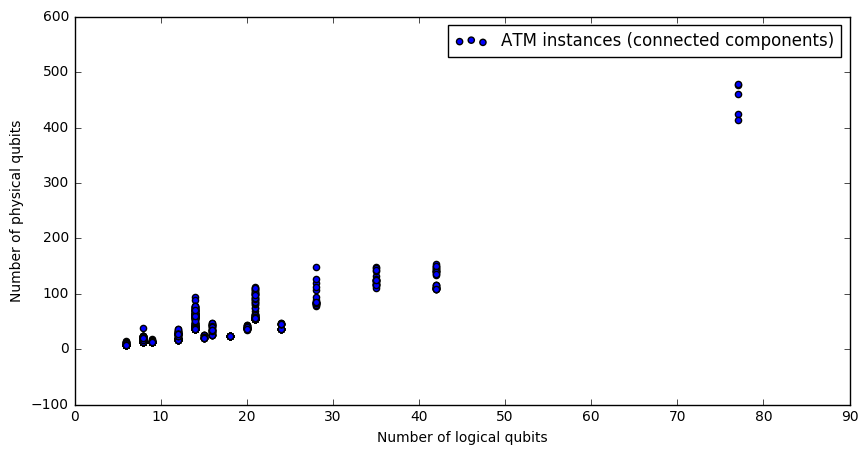

In [27]:
dvalid = iv[iv['isValid']==True]
nLogQubitsSuccess = dvalid.NLogQubits
nPhyQubitsSuccess = dvalid.NPhysQubits
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(nLogQubitsSuccess, nPhyQubitsSuccess, label='ATM instances (connected components)');
ax.set_xlabel('Number of logical qubits')
ax.set_ylabel('Number of physical qubits')
ax.legend();
plt.show();

## Success probability in dependence of the number of delay steps ##
The maximum delay is always 18 minutes. The delay step size is 3, 6 or 9. 

In [28]:
dvalid = iv[iv['isValid']==True]
dd = dvalid.reset_index()
ddd = dd[dd.instance.apply(lambda e: "_delayStep009" in e)]
successProb_d9 = ddd['SuccessProbability'].dropna().values

ddd = dd[dd.instance.apply(lambda e: "_delayStep006" in e)]
successProb_d6 = ddd['SuccessProbability'].dropna().values

ddd = dd[dd.instance.apply(lambda e: "_delayStep003" in e)]
successProb_d3 = ddd['SuccessProbability'].dropna().values

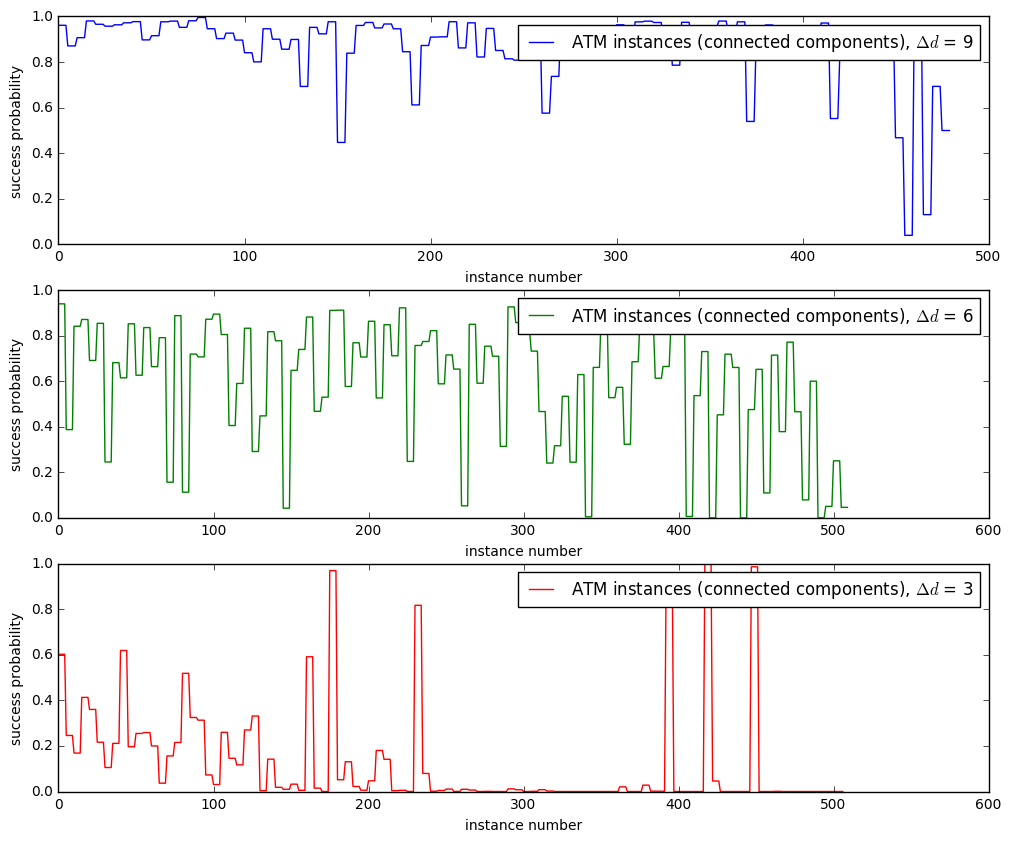

In [51]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_xlabel('instance number')
ax1.set_ylabel('success probability')

ax2 = fig.add_subplot(3, 1, 2)
ax2.set_xlabel('instance number')
ax2.set_ylabel('success probability')

ax3 = fig.add_subplot(3, 1, 3)
ax3.set_xlabel('instance number')
ax3.set_ylabel('success probability')

ax1.plot(successProb_d9, label='ATM instances (connected components), $\Delta d$ = 9');
ax2.plot(successProb_d6, c='g', label='ATM instances (connected components), $\Delta d$ = 6');
ax3.plot(successProb_d3, c='r', label='ATM instances (connected components), $\Delta d$ = 3');

ax1.legend()
ax2.legend()
ax3.legend();


## Success probability depending on instance parameters ##

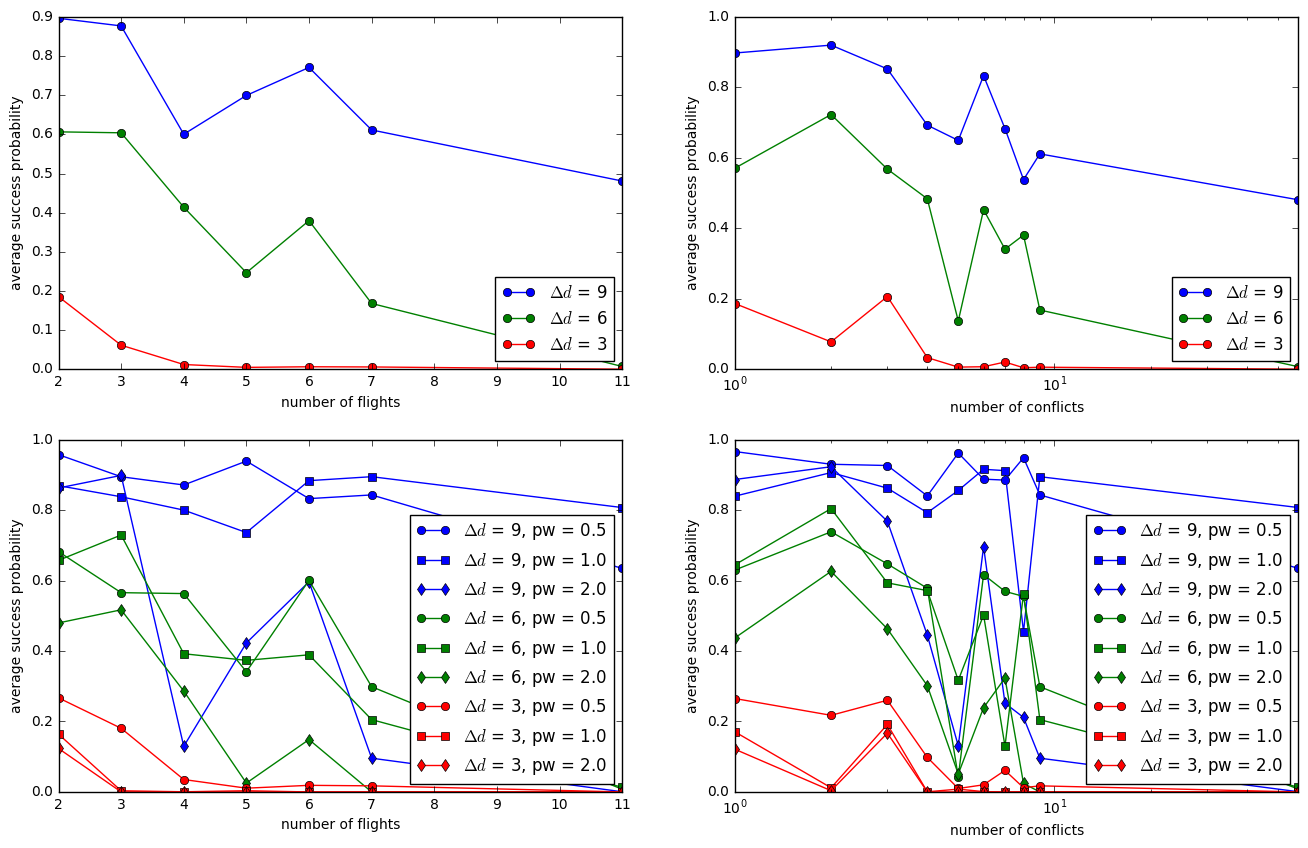

In [48]:
# vs. flights
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numFlights')['SuccessProbability'].mean()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numFlights')['SuccessProbability'].mean()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numFlights')['SuccessProbability'].mean()

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(2,2,1)
d9.plot(marker = 'o', label='$\Delta d$ = 9', ax=ax1)
d6.plot(marker = 'o', label='$\Delta d$ = 6', ax=ax1)
d3.plot(marker = 'o', label='$\Delta d$ = 3', ax=ax1)
ax1.set_ylabel('average success probability');
ax1.set_xlabel('number of flights');
ax1.legend(loc='lower right');

# vs. conflicts
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numConflicts')['SuccessProbability'].mean()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numConflicts')['SuccessProbability'].mean()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numConflicts')['SuccessProbability'].mean()

ax2 = fig.add_subplot(2,2,2)
d9.plot(marker = 'o', label='$\Delta d$ = 9', ax=ax2)
d6.plot(marker = 'o', label='$\Delta d$ = 6', ax=ax2)
d3.plot(marker = 'o', label='$\Delta d$ = 3', ax=ax2)
ax2.set_xscale('log')
ax2.set_ylabel('average success probability');
ax2.set_xlabel('number of conflicts');
ax2.legend(loc='lower right');

# vs. flights, different penalty weights
d3_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d3_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d3_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()

ax3 = fig.add_subplot(2,2,3)
d9_pw05.plot(marker = 'o', c='b', label='$\Delta d$ = 9, pw = 0.5', ax=ax3)
d9_pw10.plot(marker = 's', c='b', label='$\Delta d$ = 9, pw = 1.0', ax=ax3)
d9_pw20.plot(marker = 'd', c='b', label='$\Delta d$ = 9, pw = 2.0', ax=ax3)
d6_pw05.plot(marker = 'o', c='g', label='$\Delta d$ = 6, pw = 0.5', ax=ax3)
d6_pw10.plot(marker = 's', c='g', label='$\Delta d$ = 6, pw = 1.0', ax=ax3)
d6_pw20.plot(marker = 'd', c='g', label='$\Delta d$ = 6, pw = 2.0', ax=ax3)
d3_pw05.plot(marker = 'o', c='r', label='$\Delta d$ = 3, pw = 0.5', ax=ax3)
d3_pw10.plot(marker = 's', c='r', label='$\Delta d$ = 3, pw = 1.0', ax=ax3)
d3_pw20.plot(marker = 'd', c='r', label='$\Delta d$ = 3, pw = 2.0', ax=ax3)
ax3.set_ylabel('average success probability');
ax3.set_xlabel('number of flights');
ax3.legend(loc='lower right');

# vs. conflicts, different penalty weights
d3_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numConflicts')['SuccessProbability'].mean()
d3_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numConflicts')['SuccessProbability'].mean()
d3_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numConflicts')['SuccessProbability'].mean()
d6_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numConflicts')['SuccessProbability'].mean()
d6_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numConflicts')['SuccessProbability'].mean()
d6_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numConflicts')['SuccessProbability'].mean()
d9_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numConflicts')['SuccessProbability'].mean()
d9_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numConflicts')['SuccessProbability'].mean()
d9_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numConflicts')['SuccessProbability'].mean()

ax4 = fig.add_subplot(2,2,4)
d9_pw05.plot(marker = 'o', c='b', label='$\Delta d$ = 9, pw = 0.5', ax=ax4)
d9_pw10.plot(marker = 's', c='b', label='$\Delta d$ = 9, pw = 1.0', ax=ax4)
d9_pw20.plot(marker = 'd', c='b', label='$\Delta d$ = 9, pw = 2.0', ax=ax4)
d6_pw05.plot(marker = 'o', c='g', label='$\Delta d$ = 6, pw = 0.5', ax=ax4)
d6_pw10.plot(marker = 's', c='g', label='$\Delta d$ = 6, pw = 1.0', ax=ax4)
d6_pw20.plot(marker = 'd', c='g', label='$\Delta d$ = 6, pw = 2.0', ax=ax4)
d3_pw05.plot(marker = 'o', c='r', label='$\Delta d$ = 3, pw = 0.5', ax=ax4)
d3_pw10.plot(marker = 's', c='r', label='$\Delta d$ = 3, pw = 1.0', ax=ax4)
d3_pw20.plot(marker = 'd', c='r', label='$\Delta d$ = 3, pw = 2.0', ax=ax4)
ax4.set_xscale('log')
ax4.set_ylabel('average success probability');
ax4.set_xlabel('number of conflicts');
ax4.legend(loc='lower right');

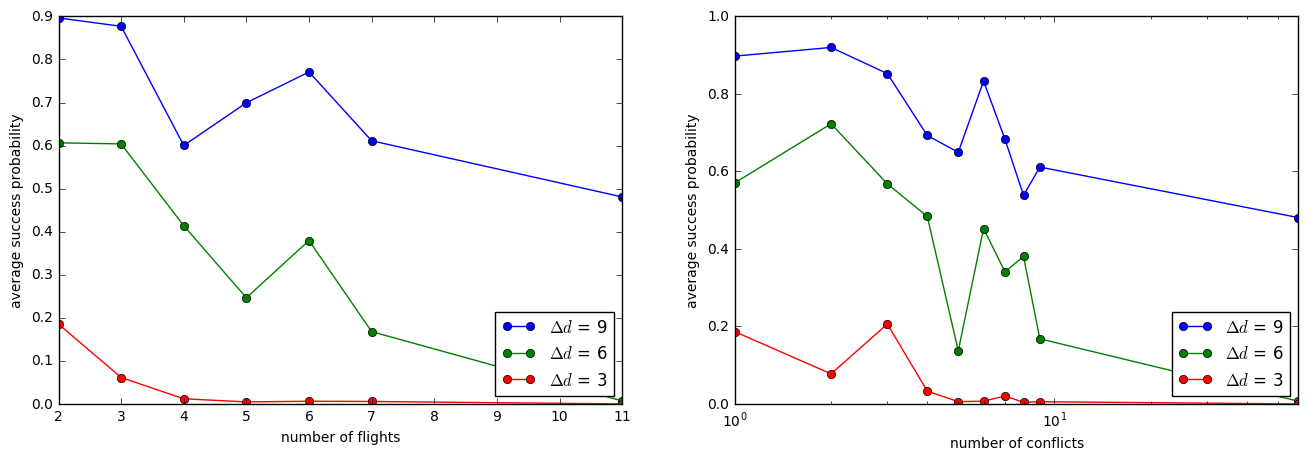

In [57]:
# vs. flights
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numFlights')['SuccessProbability'].mean()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numFlights')['SuccessProbability'].mean()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numFlights')['SuccessProbability'].mean()

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
d9.plot(marker = 'o', label='$\Delta d$ = 9', ax=ax1)
d6.plot(marker = 'o', label='$\Delta d$ = 6', ax=ax1)
d3.plot(marker = 'o', label='$\Delta d$ = 3', ax=ax1)
ax1.set_ylabel('average success probability');
ax1.set_xlabel('number of flights');
ax1.legend(loc='lower right');

# vs. conflicts
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numConflicts')['SuccessProbability'].mean()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numConflicts')['SuccessProbability'].mean()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numConflicts')['SuccessProbability'].mean()

ax2 = fig.add_subplot(1,2,2)
d9.plot(marker = 'o', label='$\Delta d$ = 9', ax=ax2)
d6.plot(marker = 'o', label='$\Delta d$ = 6', ax=ax2)
d3.plot(marker = 'o', label='$\Delta d$ = 3', ax=ax2)
ax2.set_xscale('log')
ax2.set_ylabel('average success probability');
ax2.set_xlabel('number of conflicts');
ax2.legend(loc='lower right');

# vs. flights, different penalty weights
d3_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d3_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d3_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()

pdf = matplotlib.backends.backend_pdf.PdfPages('annealing_results_success_vs_flights_and_conflicts.pdf');
pdf.savefig(figure=fig);
pdf.close();

## Maximum coefficient range ratio of embedded QUBO for different delay step sizes ##

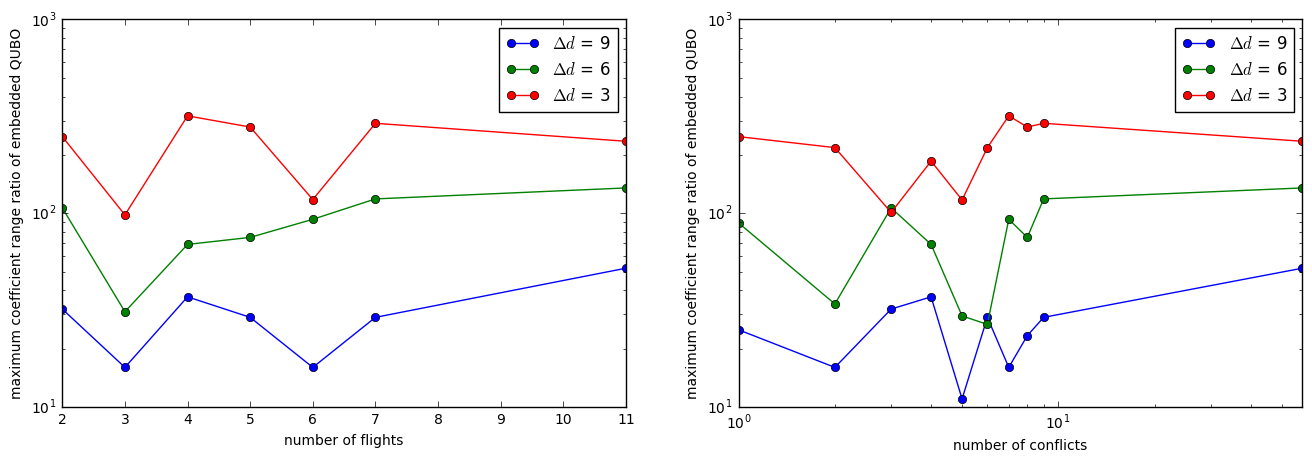

In [63]:
# vs. flights
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numFlights')['maxCoefficientRangeRatioEmbedded'].max()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numFlights')['maxCoefficientRangeRatioEmbedded'].max()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numFlights')['maxCoefficientRangeRatioEmbedded'].max()

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
d9.plot(marker = 'o', label='$\Delta d$ = 9', ax=ax1)
d6.plot(marker = 'o', label='$\Delta d$ = 6', ax=ax1)
d3.plot(marker = 'o', label='$\Delta d$ = 3', ax=ax1)
ax1.set_ylabel('maximum coefficient range ratio of embedded QUBO');
ax1.set_xlabel('number of flights');
ax1.legend();
ax1.set_yscale('log')


# vs. conflicts
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numConflicts')['maxCoefficientRangeRatioEmbedded'].max()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numConflicts')['maxCoefficientRangeRatioEmbedded'].max()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numConflicts')['maxCoefficientRangeRatioEmbedded'].max()

ax2 = fig.add_subplot(1,2,2)
d9.plot(marker = 'o', label='$\Delta d$ = 9', ax=ax2)
d6.plot(marker = 'o', label='$\Delta d$ = 6', ax=ax2)
d3.plot(marker = 'o', label='$\Delta d$ = 3', ax=ax2)
ax2.set_ylabel('maximum coefficient range ratio of embedded QUBO');
ax2.set_xlabel('number of conflicts');
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend();

pdf = matplotlib.backends.backend_pdf.PdfPages('annealing_results_coefficent_range_ratio_vs_flights_and_conflicts.pdf');
pdf.savefig(figure=fig);
pdf.close();

## Maximum coefficient range ratio of the QUBO before embedding ##

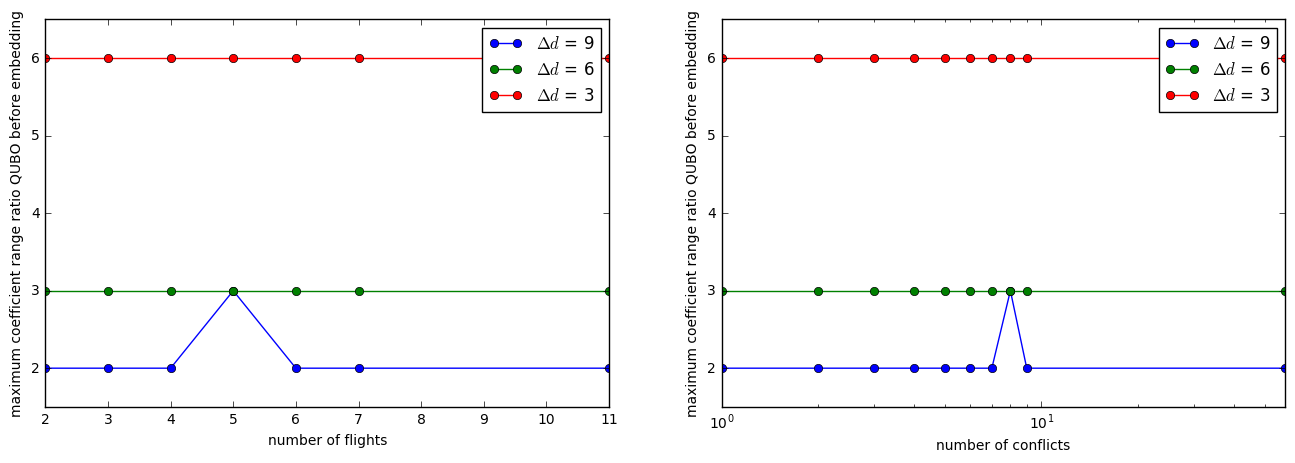

In [66]:
# vs. flights
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numFlights')['maxCoefficientRangeRatio'].max()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numFlights')['maxCoefficientRangeRatio'].max()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numFlights')['maxCoefficientRangeRatio'].max()

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
d9.plot(marker = 'o', label='$\Delta d$ = 9', ax=ax1)
d6.plot(marker = 'o', label='$\Delta d$ = 6', ax=ax1)
d3.plot(marker = 'o', label='$\Delta d$ = 3', ax=ax1)
ax1.set_ylim(1.5, 6.5)
ax1.set_ylabel('maximum coefficient range ratio QUBO before embedding');
ax1.set_xlabel('number of flights');
ax1.legend();


# vs. conflicts
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numConflicts')['maxCoefficientRangeRatio'].max()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numConflicts')['maxCoefficientRangeRatio'].max()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numConflicts')['maxCoefficientRangeRatio'].max()

ax2 = fig.add_subplot(1,2,2)
d9.plot(marker = 'o', label='$\Delta d$ = 9', ax=ax2)
d6.plot(marker = 'o', label='$\Delta d$ = 6', ax=ax2)
d3.plot(marker = 'o', label='$\Delta d$ = 3', ax=ax2)
ax2.set_ylim(1.5, 6.5)
ax2.set_ylabel('maximum coefficient range ratio QUBO before embedding');
ax2.set_xlabel('number of conflicts');
ax2.set_xscale('log')
ax2.legend();

pdf = matplotlib.backends.backend_pdf.PdfPages('annealing_results_coefficent_range_ratio_vs_flights_and_conflicts_before_embedding.pdf');
pdf.savefig(figure=fig);
pdf.close();

## Correlation of low success probability with high ratio of coefficients in the embedded QUBO ##

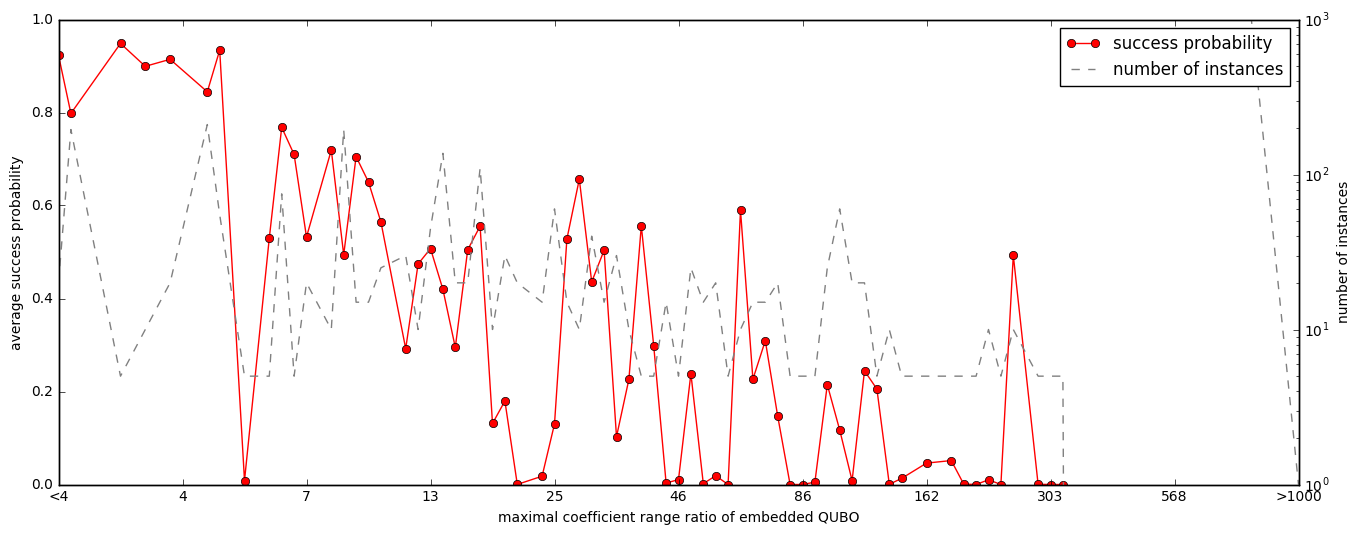

In [60]:
iv = inventoryProcessed
crr_min = iv.maxCoefficientRangeRatio.min()
crr_max = iv.maxCoefficientRangeRatio.max()
bins = np.logspace(np.log2(crr_min)+1, np.log2(1000), 100, base=2)
x = iv.groupby(np.digitize(iv.maxCoefficientRangeRatioEmbedded, bins))['SuccessProbability'].mean()
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 1, 1)
x.plot(marker='o', color='r', ax=ax1, label='success probability');
ticks = range(0, 110, 10)
labels = ['<4'] + [int(np.round(bins[t])) for t in ticks[1:-1]] + ['>1000']
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels)
ax1.set_xlabel('maximal coefficient range ratio of embedded QUBO')
ax1.set_ylabel('average success probability');

y = iv.groupby(np.digitize(iv.maxCoefficientRangeRatioEmbedded, bins))['SuccessProbability'].count()
ax2 = ax1.twinx()
y.plot(linestyle='--', color='gray', ax=ax2, label='number of instances');
y.plot(linestyle='--', color='gray', ax=ax1, label='number of instances');
ax1.set_ybound(upper=1)
ax2.set_ylabel('number of instances');
ax2.set_yscale('log')
ax1.legend(loc='upper right');

pdf = matplotlib.backends.backend_pdf.PdfPages('annealing_results_success_vs_cooefficent_range_ratio.pdf');
pdf.savefig(figure=fig);
pdf.close();